---

<h1 align="center">Short-term Temperature Forecast 
    <h2 align="center">~ Analyzing Time Series with ARIMA ~
</h2>

---
__1) The Goal:__ Create a short-term temperature forecast based on the Mean temperature data provided by ECA\&D (European Climate Assessment \& Dataset) for Berlin-Tempelhof.    

__2) Get the Data:__ Download the data for Berlin-Tempelhof from ECAD following the instructions provided under the challenge called ["Read the data"](https://krspiced.pythonanywhere.com/chapters/project_temperature/README.html).

__3) Clean \& Prepare the Data (EDA \& Train-Test-Split):__ Transform the dates to timestamp and drop the dates before 1945-11-06 because there are missing values.   
     
__4) Feature Engineering (FE):__ A special kind kind of feature engineering: **Time Series Decomposition**.
    
__6) Train a Model:__ A special variant of the Linear Regression: **Linear Autoregression** (Autoregressive Model)   
    
__7) Evaluate the Model:__ Cross-Validation and AIC (Akaike Information Criterion)  

- ARIMA model **(Thursday Afternoon)**
    - Autoregressive Integrated Moving Average Model  
    
    
The AR model (Linear Autoregression) and the ARIMA model are ONLY USEFUL for short-term forecasts!!!

__10) Test the Model:__    
    
---

<h2 align="center", style="color:green"><strong>Get Data and Clean it (EDA)</strong></h2>

---

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

plt.rcParams['figure.figsize'] = (12,6)

In [2]:
# Read the data to get the date column name
draft1 = pd.read_csv(os.getenv('ecad_path')+'TG_STAID002759.txt', skiprows=19) 
draft1.columns

Index([' SOUID', '    DATE', '   TG', ' Q_TG'], dtype='object')

In [3]:
# Read the data and make the date column index
raw_data = pd.read_csv(os.getenv('ecad_path')+'TG_STAID002759.txt', skiprows=19, index_col=[draft1.columns[1]], parse_dates=True) 

# Drop the date column from the draft so that the number of columns matches raw_data
draft2 = draft1.drop(draft1.columns[1], axis=1)

# Clean-up the column names:
raw_data.columns = draft2.columns.str.lower().str.strip()
raw_data.columns

Index(['souid', 'tg', 'q_tg'], dtype='object')

In [4]:
# Check which temperature values are missing (i.e. q_tg ==9):
raw_data[raw_data['q_tg']==9]

# The index of the first temperature available after missing values:
start_index = raw_data[raw_data['q_tg']==9].index.max()+(timedelta(days=1))
print(f'Keep temperature data from {start_index.date()} onwards.')

# Keep data from that point onward:
less_data = raw_data.loc[start_index:].copy()

Keep temperature data from 1945-11-06 onwards.


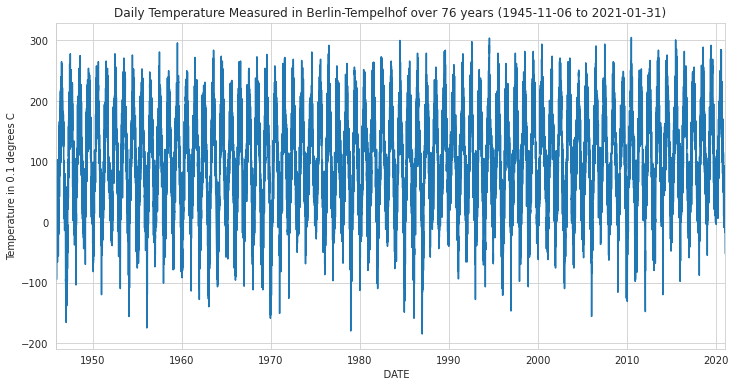

In [5]:
# Rename 'tg' column to 'temp' and drop the 'souid' and 'q_tg' columns:
data = less_data.drop(columns=['souid','q_tg']).rename(columns={'tg':'temp'}).copy()

# Plot the data
data['temp'].plot()
plt.title(f'Daily Temperature Measured in Berlin-Tempelhof over {(data.index.max().year-data.index.min().year)} years ({data.index.min().date()} to {data.index.max().date()})')
plt.ylabel('Temperature in 0.1 degrees C')
plt.show();

--------------------------

<h2 align="center", style="color:green"><strong>Prepare the Data (Train-Test-Split)</strong></h2>  

---

In [6]:
print(f'The data spans over {(data.index.max()-data.index.min()).days} days ({(data.index.max().year-data.index.min().year)} years). \nTo split it into 80% training - 20% testing data: \n{round(0.8*len(data))} days for the trainindaystaset \n{round(0.2*len(data))} days for test dataset')

The data spans over 27480 days (76 years). 
To split it into 80% training - 20% testing data: 
21985 days for the trainindaystaset 
5496 days for test dataset


In [7]:
# Create a timestep column (this will be the trend)
data['timestep'] = list(range(len(data)))

# Create the seasonal dummies for seasonality
seasonal_dummies = pd.get_dummies(data.index.month,
                                  prefix='month',
                                  drop_first=True).set_index(data.index)

data_ts = data.join(seasonal_dummies).copy()

# And split the data into train & test
train = data_ts[data_ts['timestep'] < round(0.8*len(data))].copy()
test = data_ts[data_ts['timestep'] >= round(0.8*len(data))].copy()
train.head(2)

,temp,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,
1945-11-06,78,0,0,0,0,0,0,0,0,0,0,1,0
1945-11-07,68,1,0,0,0,0,0,0,0,0,0,1,0


--------------------------

<h2 align="center", style="color:green"><strong>Time Series Decomposition (FE)</strong></h2>  

---

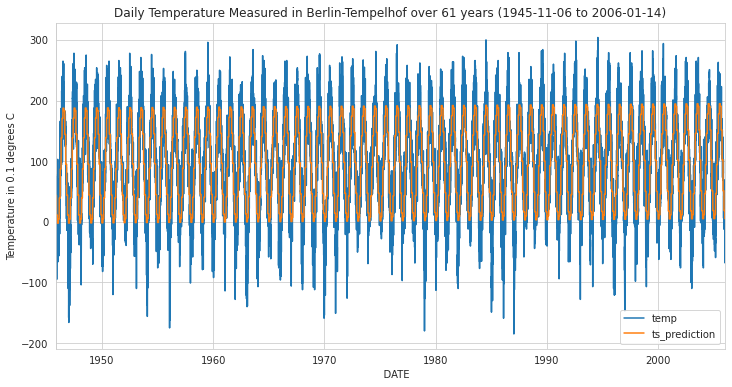

In [8]:
# Define X and y
X = train.drop(columns=['temp'])
y = train['temp']

# Create and fit the ts model (trend-seasonal model)
m_ts = LinearRegression()
m_ts.fit(X, y)

# Create a new column with the predictions of the trend_seasonal model
train['ts_prediction'] = m_ts.predict(X)


# Plot the original data and the ts model
train[['temp', 'ts_prediction']].plot()
plt.title(f'Daily Temperature Measured in Berlin-Tempelhof over {(train.index.max().year-train.index.min().year)} years ({train.index.min().date()} to {train.index.max().date()})')
plt.ylabel('Temperature in 0.1 degrees C')
plt.show();

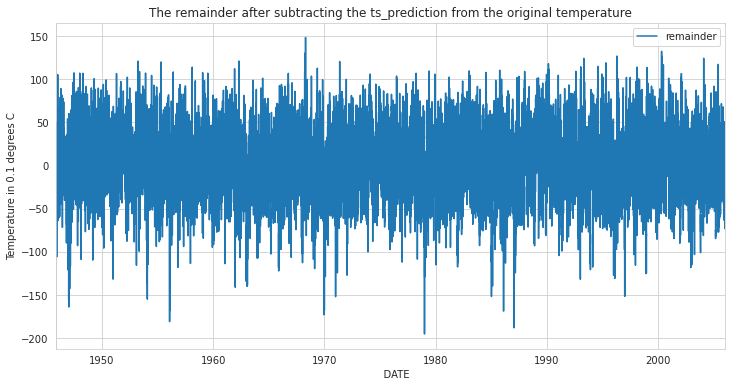

In [9]:
# Extract the remainder: We want the part of the model that the ts model is not able to explain
train['remainder'] = train['temp'] - train['ts_prediction']

# Plot the remainder
train[['remainder']].plot()
plt.title(f'The remainder after subtracting the ts_prediction from the original temperature')
plt.ylabel('Temperature in 0.1 degrees C')
plt.show();


According to the Partial Autocorrelation figure below, 
the AR model can predict the temperature up to 3 days ahead (lag3). 




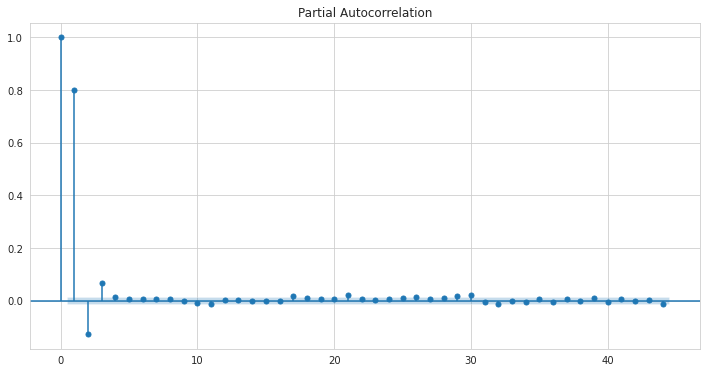

In [10]:
# Inspect the remainder to decide how many lags to include
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train['remainder']);
print('\nAccording to the Partial Autocorrelation figure below, \nthe AR model can predict the temperature up to 3 days ahead (lag3). \n\n')

--------------------------

<h2 align="center", style="color:green"><strong>Train the Model: AR (Autoregressive Model)</strong></h2>  

---

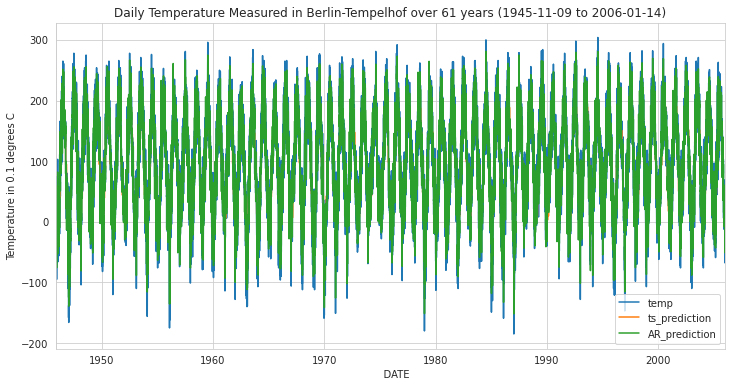

In [11]:
# Add the lags of the remainder to the training data
train['lag1'] = train['remainder'].shift(1)
train['lag2'] = train['remainder'].shift(2)
train['lag3'] = train['remainder'].shift(3)
train.dropna(inplace=True)

# Define X and y
X_AR = train.drop(columns=['temp', 'ts_prediction', 'remainder'])
y_AR = train['temp']

# Train the model
m_AR = LinearRegression()
m_AR.fit(X_AR, y_AR)

# Create a new predictions column for the AR_prediction
train['AR_prediction'] = m_AR.predict(X_AR)

# Plot the original data and the ts and AR models
train[['temp', 'ts_prediction', 'AR_prediction']].plot()
plt.title(f'Daily Temperature Measured in Berlin-Tempelhof over {(train.index.max().year-train.index.min().year)} years ({train.index.min().date()} to {train.index.max().date()})')
plt.ylabel('Temperature in 0.1 degrees C')
plt.show();

--------------------------

<h2 align="center", style="color:green"><strong>Evaluate the Model</strong></h2>
<h2 align='center', style="color:green"><strong>Cross-validation & AIC (Akaike Information Criterion)</strong></h2>  

---

### Cross-validation:  

In [12]:
# Create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=5)

In [13]:
# To see how the folds were made: 
for i, (train_index, validation_index) in enumerate(ts_split.split(X_AR, y_AR)):
    print(f'The training data for the {i+1}th iteration are the observations {train_index[0]} to {train_index[-1]}')
    print(f'The validation data for the {i+1}th iteration are the observations {validation_index[0]} to {validation_index[-1]}')
    print()

The training data for the 1th iteration are the observations 0 to 3666
The validation data for the 1th iteration are the observations 3667 to 7329

The training data for the 2th iteration are the observations 0 to 7329
The validation data for the 2th iteration are the observations 7330 to 10992

The training data for the 3th iteration are the observations 0 to 10992
The validation data for the 3th iteration are the observations 10993 to 14655

The training data for the 4th iteration are the observations 0 to 14655
The validation data for the 4th iteration are the observations 14656 to 18318

The training data for the 5th iteration are the observations 0 to 18318
The validation data for the 5th iteration are the observations 18319 to 21981



In [14]:
# Create the time series split
time_series_split = ts_split.split(X_AR, y_AR)

# Do the cross validation
result = cross_val_score(estimator=m_AR, X=X_AR, y=y_AR, cv=time_series_split)

# scores are R-sqaured (default for Linear Regression in scikitlearn)
print(f'The cross validation score of the AR model is {round(result.mean(), 2)}.')

The cross validation score of the AR model is 0.91.


### AIC (Akaike Information Criterion)
$2k − 2ln(\hat{L})$

Also Goodness-of-Fit-Measure. Relative information value, lower is better. Penalizes models with many parameters.  
Useful to compare models trained on the same dataset.

In [15]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

regr = OLS(y_AR, add_constant(X_AR)).fit()
print(f'\nThe AIC for the AR model is {round(regr.aic,2)}. The full summary is:\n\n')
regr.summary()


The AIC for the AR model is 201048.15. The full summary is:




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   temp   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                 1.537e+04
Date:                Fri, 26 Feb 2021   Prob (F-statistic):               0.00
Time:                        15:37:23   Log-Likelihood:            -1.0051e+05
No. Observations:               21982   AIC:                         2.010e+05
Df Residuals:                   21966   BIC:                         2.012e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8905      0.606     -3.121      0.002      -3.078      -0.703
timestep       0.0003   2.49e-05     13.878      0.000       0.000       0.000
month_2        6.7393      0.785      8.584      0.000       5.200       8.278
month_3       41.4466      0.767     54.063      0.000      39.944      42.949
month_4       88.8079      0.773    114.881      0.000      87.293      90.323
month_5      139.8648      0.767    182.424      0.000     138.362     141.368
month_6      172.2450      0.773    222.808      0.000     170.730     173.760
month_7      189.2863      0.767    246.901      0.000     187.784     190.789
month_8      184.2680      0.767    240.305      0.000     182.765     185.771
month_9      145.6535      0.773    188.409      0.000     144.138     147.169
month_10      96.3147      0.767    125.625      0.000      94.812      97.817
month_11      45.7111      0.771     59.316      0.000      44.201      47.222
month_12      12.8337      0.763     16.809      0.000      11.337      14.330
lag1           0.9115      0.007    135.404      0.000       0.898       0.925
lag2          -0.1866      0.009    -20.668      0.000      -0.204      -0.169
lag3           0.0676      0.007     10.040      0.000       0.054       0.081
==============================================================================
Omnibus:                      283.008   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              474.938
Skew:                          -0.094   Prob(JB):                    7.39e-104
Kurtosis:                       3.695   Cond. No.                     1.57e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.57e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

--------------------------

<h2 align="center", style="color:green"><strong>Test the model</strong></h2>  

---

In [16]:
# The test data has already a timestep and seasonal dummies
test.head(2)

,temp,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,
2006-01-15,-51,21985,0,0,0,0,0,0,0,0,0,0,0
2006-01-16,-55,21986,0,0,0,0,0,0,0,0,0,0,0


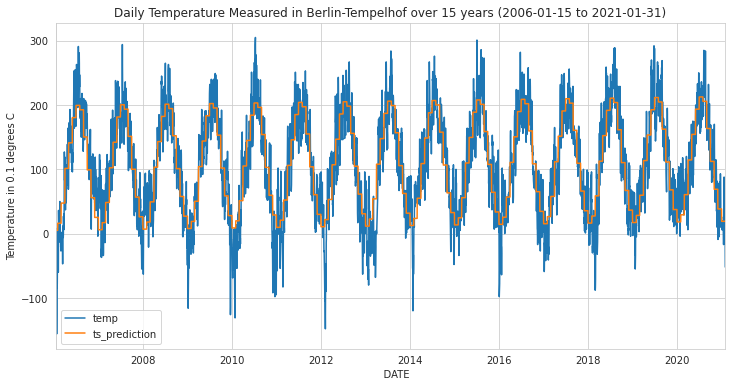

In [17]:
# Define X and y for the ts model
X_test = test.drop(columns=['temp'])
y_test = test['temp']

# Create and fit the ts model (trend-seasonal model)
m_ts = LinearRegression()
m_ts.fit(X_test, y_test)

# Create a new column with the predictions of the trend_seasonal model
test['ts_prediction'] = m_ts.predict(X_test)


# Plot the original data and the ts model
test[['temp', 'ts_prediction']].plot()
plt.title(f'Daily Temperature Measured in Berlin-Tempelhof over {(test.index.max().year-test.index.min().year)} years ({test.index.min().date()} to {test.index.max().date()})')
plt.ylabel('Temperature in 0.1 degrees C')
plt.show();

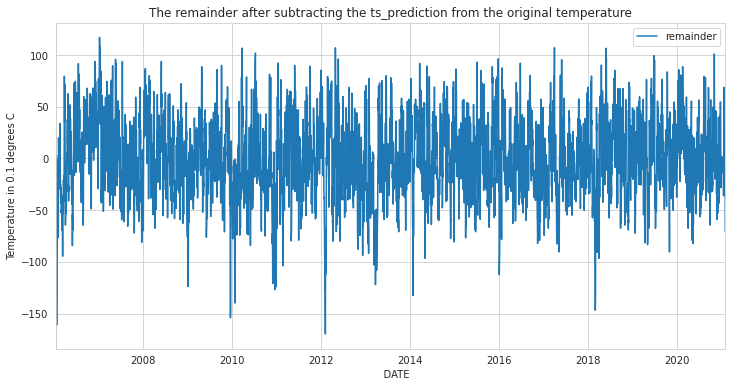

In [18]:
# Extract the remainder: We want the part of the model that the ts model is not able to explain
test['remainder'] = test['temp'] - test['ts_prediction']

# Plot the remainder
test[['remainder']].plot()
plt.title(f'The remainder after subtracting the ts_prediction from the original temperature')
plt.ylabel('Temperature in 0.1 degrees C')
plt.show();


According to the Partial Autocorrelation figure below, 
the AR model can predict the temperature up to 3 days ahead (lag3). 




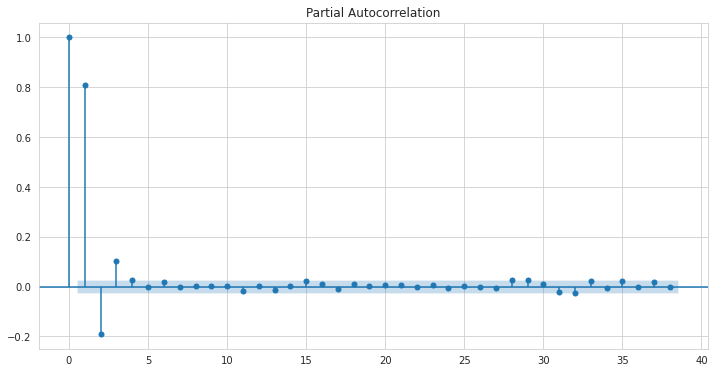

In [19]:
# Inspect the remainder to decide how many lags to include
# from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(test['remainder']);
print('\nAccording to the Partial Autocorrelation figure below, \nthe AR model can predict the temperature up to 3 days ahead (lag3). \n\n')

In [20]:
# Add the lags of the remainder to the training data
test['lag1'] = test['remainder'].shift(1)
test['lag2'] = test['remainder'].shift(2)
test['lag3'] = test['remainder'].shift(3)

# Fill in the lag gaps
def lags(df_lag, df_past, N, lag_prefix='lag', col_remainder='remainder', t_unit='days'):
    '''
    Fill the lags for a test_df or a future_df used in a timeseries analysis
    df_lag: DataFrame (data to be tested/predicted for the future) with lags to be filled
    df_past: DataFrame (data from the train/past) with the remainders that can be used to fill the lags in the future
    N: Number of lags
    lag_prefix: The prefix of the lag columns as a string, it is assumed that the lag columns are named as lag1, lag2,...,lagN\n
    where (lag) is the prefix
    col_remainder: The name of the remainder column in the DataFrame (Past)
    t_unit: TimeDelta unit for the minimum timestep in the index, takes TimeDelta keyword values e.g., days, months, years etc.
    '''
    df_temp = df_past[[f'{col_remainder}']][-N:].copy()
    df_temp.index += pd.Timedelta(**{f'{t_unit}':N})
    for i in range(N):
        df_temp[f'{lag_prefix}{i+1}'] = df_temp[f'{col_remainder}'].shift(i-N+1)
    return df_lag.fillna(df_temp)

test = lags(test, train, 3)

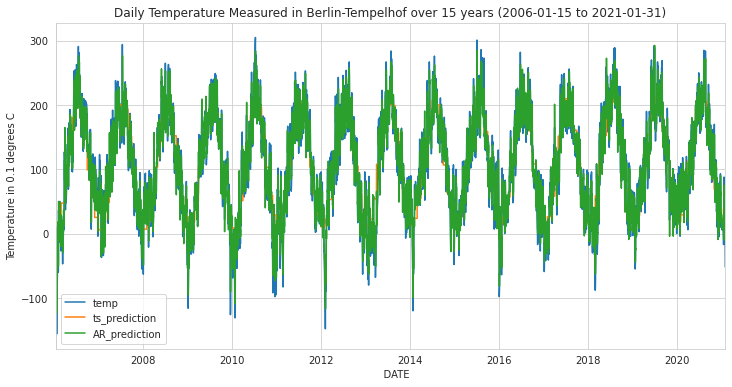

In [21]:
# Define X and y for the AR model
X_AR_test = test.drop(columns=['temp', 'ts_prediction', 'remainder'])
y_AR_test = test['temp']

# Train the model
m_AR = LinearRegression()
m_AR.fit(X_AR_test, y_AR_test)

# Create a new predictions column for the AR_prediction
test['AR_prediction'] = m_AR.predict(X_AR_test)

# Plot the original data and the ts and AR models
test[['temp', 'ts_prediction', 'AR_prediction']].plot()
plt.title(f'Daily Temperature Measured in Berlin-Tempelhof over {(test.index.max().year-test.index.min().year)} years ({test.index.min().date()} to {test.index.max().date()})')
plt.ylabel('Temperature in 0.1 degrees C')
plt.show();

In [22]:
test.head()

,temp,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,ts_prediction,remainder,lag1,lag2,lag3,AR_prediction
DATE,,,,,,,,,,,,,,,,,,,
2006-01-15,-51,21985,0,0,0,0,0,0,0,0,0,0,0,5.103190,-56.103190,-22.335638,-1.335293,20.665052,-14.399003
2006-01-16,-55,21986,0,0,0,0,0,0,0,0,0,0,0,5.105755,-60.105755,-56.103190,-22.335638,-1.335293,-43.834176
2006-01-17,-39,21987,0,0,0,0,0,0,0,0,0,0,0,5.108321,-44.108321,-60.105755,-56.103190,-22.335638,-40.138537
2006-01-18,-26,21988,0,0,0,0,0,0,0,0,0,0,0,5.110886,-31.110886,-44.108321,-60.105755,-56.103190,-26.710430
2006-01-19,-33,21989,0,0,0,0,0,0,0,0,0,0,0,5.113452,-38.113452,-31.110886,-44.108321,-60.105755,-18.966616



 The accuracy of the model is 0.92. 




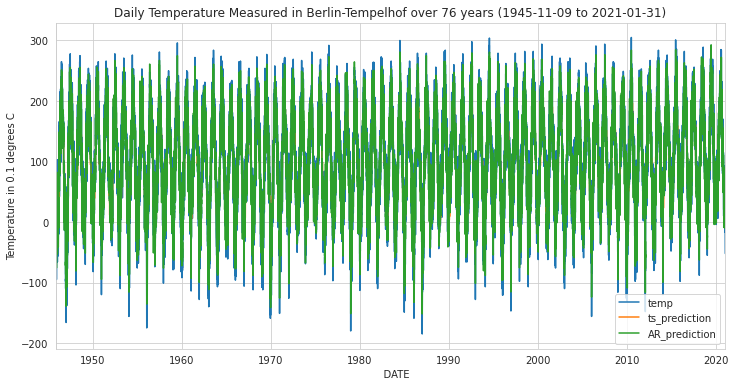

In [23]:
# Create the complete dataset and plot it
full_data = train[['temp', 'ts_prediction', 'AR_prediction']].append(test[['temp', 'ts_prediction', 'AR_prediction']])

print('\n', f'The accuracy of the model is {round(m_AR.score(X_AR_test, y_AR_test),2)}.', '\n\n')

full_data[['temp', 'ts_prediction', 'AR_prediction']].plot()
plt.title(f'Daily Temperature Measured in Berlin-Tempelhof over {(full_data.index.max().year-full_data.index.min().year)} years ({full_data.index.min().date()} to {full_data.index.max().date()})')
plt.ylabel('Temperature in 0.1 degrees C')
plt.show();

--------------------------

<h2 align="center", style="color:green"><strong>Predicting the Future</strong></h2>  

---

In [25]:
train_test = train.append(test)
train_test

,temp,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,ts_prediction,remainder,lag1,lag2,lag3,AR_prediction
DATE,,,,,,,,,,,,,,,,,,,
1945-11-09,40,3,0,0,0,0,0,0,0,0,0,1,0,43.588160,-3.588160,20.412185,24.412529,34.412874,60.196819
1945-11-10,46,4,0,0,0,0,0,0,0,0,0,1,0,43.588505,2.411495,-3.588160,20.412185,24.412529,38.391894
1945-11-11,30,5,0,0,0,0,0,0,0,0,0,1,0,43.588850,-13.588850,2.411495,-3.588160,20.412185,48.069848
1945-11-12,28,6,0,0,0,0,0,0,0,0,0,1,0,43.589195,-15.589195,-13.588850,2.411495,-3.588160,30.744055
1945-11-13,24,7,0,0,0,0,0,0,0,0,0,1,0,43.589540,-19.589540,-15.589195,-13.588850,2.411495,32.312974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-27,19,27476,0,0,0,0,0,0,0,0,0,0,0,19.190584,-0.190584,-7.188019,-5.185453,-7.182888,12.769484
2021-01-28,16,27477,0,0,0,0,0,0,0,0,0,0,0,19.193150,-3.193150,-0.190584,-7.188019,-5.185453,20.452971
2021-01-29,-12,27478,0,0,0,0,0,0,0,0,0,0,0,19.195715,-31.195715,-3.193150,-0.190584,-7.188019,15.258079


In [24]:
# Combine the train and test data with all the features (timestep, months, lags) 
train_test = train.append(test)
train_test['month'] = train_test.index.month

# Define X and y for the ts model
X_train_test = train_test.drop(columns=['temp'])
y_train_test = train_test['temp']

# Create and fit the ts model (trend-seasonal model)
m_ts = LinearRegression()
m_ts.fit(X_train_test, y_train_test)

# Create a new column with the predictions of the trend_seasonal model
train_test['ts_prediction'] = m_ts.predict(X_train_test)
train_test

,temp,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,ts_prediction,remainder,lag1,lag2,lag3,AR_prediction
DATE,,,,,,,,,,,,,,,,,,,
1945-11-09,40,3,0,0,0,0,0,0,0,0,0,1,0,40.0,-3.588160,20.412185,24.412529,34.412874,60.196819
1945-11-10,46,4,0,0,0,0,0,0,0,0,0,1,0,46.0,2.411495,-3.588160,20.412185,24.412529,38.391894
1945-11-11,30,5,0,0,0,0,0,0,0,0,0,1,0,30.0,-13.588850,2.411495,-3.588160,20.412185,48.069848
1945-11-12,28,6,0,0,0,0,0,0,0,0,0,1,0,28.0,-15.589195,-13.588850,2.411495,-3.588160,30.744055
1945-11-13,24,7,0,0,0,0,0,0,0,0,0,1,0,24.0,-19.589540,-15.589195,-13.588850,2.411495,32.312974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-27,19,27476,0,0,0,0,0,0,0,0,0,0,0,19.0,-0.190584,-7.188019,-5.185453,-7.182888,12.769484
2021-01-28,16,27477,0,0,0,0,0,0,0,0,0,0,0,16.0,-3.193150,-0.190584,-7.188019,-5.185453,20.452971
2021-01-29,-12,27478,0,0,0,0,0,0,0,0,0,0,0,-12.0,-31.195715,-3.193150,-0.190584,-7.188019,15.258079


In [25]:
# A function that creates future data (as much as the lag allows) to predict on:

def make_future(df,N,lag_prefix='lag'):
    xindex = [df.index.max() + timedelta(days=i+1) for i in range(N)]
    #xstamp = [df.timestamp[-1] + i+1 for i in range(N)]
    xfut = pd.DataFrame(xstamp,index=xindex, columns=['timestamp'])
    xfut['week'] = xfut.index.isocalendar().week
    xfut_weekly_dummies = pd.get_dummies(xfut['week'], prefix='week_', drop_first=True)
    xfut = xfut.join(xfut_weekly_dummies)
    weeks2 = [i+1 for i in range(df['week'].max())]
    this = pd.DataFrame(weeks2,columns=['week'],dtype=np.int64)
    #a = pd.merge(xfut,this,how='outer',on=['week'],left_index=True)
    a = pd.concat([this,xfut],axis=0)
    a_dummies = pd.get_dummies(a['week'], prefix='week_', drop_first=True)
    a = a.join(a_dummies)
    a = a.dropna()
    for i in range(3):
        a[f'{lag_prefix}{i+1}'] = np.nan
    a.timestamp = a.timestamp.astype(int)
    a.index=pd.to_datetime(a.index)
    return a
    #return pd.concat([this,xfut],axis=1)

In [38]:
# What is the first date in the future? 
print((train_test.index.max()+(timedelta(days=1))).date())

2021-02-01


In [40]:
# What is the first timestep in the future? 
train_test['timestep'].max()+1

27481

In [ ]:
# What is the first date in the future? --> 1961-01-01
timestep = train_test['timestep'].max() + 1
months = [0] * 11  # because it is January, which is the first dummy-feature (which we dropped)
lag = train_test.loc['1960-12-01', 'remainder']

In [ ]:
# create a new sample
X_future = []

In [ ]:
X_future.append(timestep)
X_future

In [ ]:
X_future.extend(months)
X_future

In [ ]:
X_future.append(lag)
X_future

In [ ]:
X_future = pd.DataFrame([X_future], columns = ['timestep', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12','lag1'])
X_future.rename(index={0:pd.to_datetime("1961-01-01 00:00:00")},inplace=True)
X_future

In [ ]:
# Prediction for 1961-01-01
m_combined.predict(X_future)

In [ ]:
X_future['predictions_full_model'] = m_combined.predict(X_future)

In [ ]:
# How does this look like for 1961-02-01?
timestep = flights_combined['timestep'].max() + 2
months = [1] + [0]*10
lag = 0 
# This is too far in the future to calculate the lag; our best guess will be a lag of 0. 
# So we are predicting only trend and seasonality here. 

In [ ]:
X_future_2 = pd.DataFrame([[timestep] + months + [lag]], columns = ['timestep', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12','lag1'])
X_future_2.rename(index={0:pd.to_datetime("1961-02-01 00:00:00")},inplace=True)
X_future_2

In [ ]:
# Prediction for 1961-02-01
m_combined.predict(X_future_2)

In [ ]:
X_future_2['predictions_full_model'] = m_combined.predict(X_future_2)

In [ ]:
# create one df for plotting
cols = ['timestep', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'lag1', 'passengers', 'trend_seasonal', 'predictions_full_model']
flights_f = flights_test[cols].append(X_future)
flights_future = flights_f.append(X_future_2)

In [ ]:
plot_flights(flights_future[['passengers', 'trend_seasonal', 'predictions_full_model']], ylim=False)


---

<h2 align="center"><a href="https://www.sktime.org/en/latest/examples/01_forecasting.html">Forecasting with sktime</a></h2 align="center">  

---

### Specifying the forecasting task

In [11]:
print('The data spans over {} days ({} years). We will split it into 80% training - 20% testing data. This means {} days for the training dataset and {} days for test dataset'.format((data.index[-1]-data.index[0]).days,(data.index[-1].year-data.index[0].year),(0.8*(data.index[-1]-data.index[0])).days, (0.2*(data.index[-1]-data.index[0])).days))

The data spans over 27480 days (76 years). We will split it into 80% training - 20% testing data. This means 21984 days for the training dataset and 5496 days for test dataset


In [12]:
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.utils.plotting import plot_series

In [13]:
sktime_data = data.reset_index()
sktime_data

,date,temp
0,1945-11-06,78
1,1945-11-07,68
2,1945-11-08,64
3,1945-11-09,40
4,1945-11-10,46
...,...,...
27476,2021-01-27,19
27477,2021-01-28,16
27478,2021-01-29,-12
27479,2021-01-30,-12


In [14]:
y = sktime_data['temp']
y_train, y_test = temporal_train_test_split(y, test_size=(0.2*(data.index[-1]-data.index[0])).days)
print(y_train.shape[0], y_test.shape[0])

21985 5496


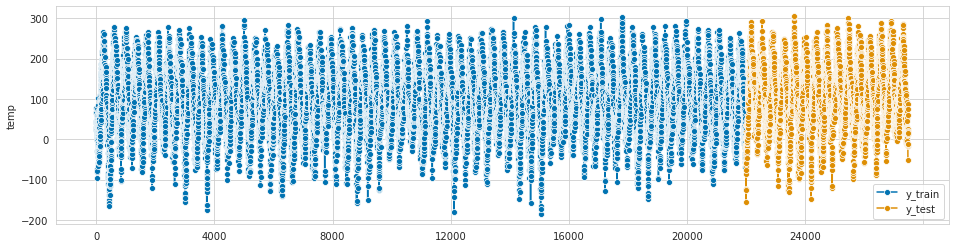

In [15]:
plot_series(y_train, y_test, labels=["y_train", "y_test"]);

---

### Relative forecasting horizon

In [16]:
fh = np.arange(len(y_test))+1
fh

array([   1,    2,    3, ..., 5494, 5495, 5496])

---

### Absolute forecasting horizon

In [17]:
from sktime.forecasting.base import ForecastingHorizon

In [18]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

ForecastingHorizon([21985, 21986, 21987, 21988, 21989, 21990, 21991, 21992, 21993,
            21994,
            ...
            27471, 27472, 27473, 27474, 27475, 27476, 27477, 27478, 27479,
            27480],
           dtype='int64', length=5496, is_relative=False)

---

### Generating forecasts  

Let’s start with two naïve forecasting strategies which can serve as references for comparison of more sophisticated approaches.  

### 1) Predicting the last value

In [19]:
from sktime.forecasting.naive import NaiveForecaster

from sktime.performance_metrics.forecasting import sMAPE, smape_loss

1.9040699747236298

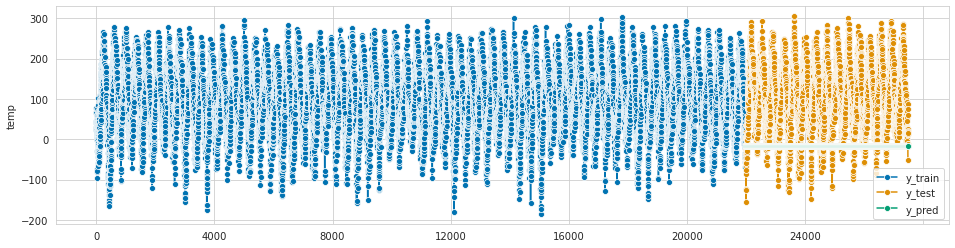

In [20]:
# using sktime
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)

### 2) Predicting the last value of the same season

1.7958406045086592

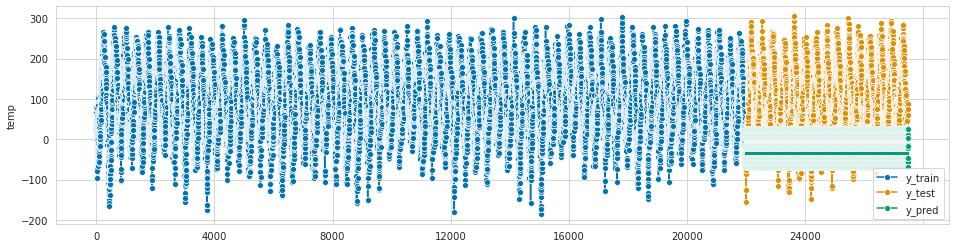

In [21]:
forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)

---

### Forecasting with sktime

In [41]:
from sktime.forecasting.compose import (
    EnsembleForecaster,
    ReducedRegressionForecaster,
    TransformedTargetForecaster,
)

ImportError: cannot import name 'ReducedRegressionForecaster' from 'sktime.forecasting.compose' (/home/aksoyoglu/anaconda3/lib/python3.8/site-packages/sktime/forecasting/compose/__init__.py)